# Exercises

The goal of this exercise is to analyse data taken by a radio receiver. You will study the statistical properties of thermal noise, and measure the noise temperature of some receiver. Since we are doing this remotely, I wrote a short code that generates mock data, but let's imagine together that it really does come from some commercially available receiver. Let's quickly look at one such receiver, the **AirSpy**, since this is the one we were using when this course was in person. A picture of the interior of the device is shown below.

<center><img src="Airspy_pic.png" /></center>

The AirSpy is a heterodyne receiver and can record up to $10^7$ samples per seconds, i.e. $\Delta t = 10^{-7}$ seconds, or 100 ns, which corresponds to a sampling rate of 10 MHz, and hence, a maximum bandwidth of 5 MHz. Thanks to its heterodyne mixer, it is tunable to any frequency between 24 and 1800 MHz. Below is a schematic of the relevant components that are relevant to the exercise.

<center><img src="schematic.png"></center>

- The **antenna** would typically be some sort of feed, such as a dipole or a horn, to couple the free space with the waveguide (cable). In this exercise, however, we will be connecting a terminating load (resistor) and vary its temperature to inspect the statistical properties of its noise, and measure the receiver temperature.
- The **low noise amplifier (LNA)** amplifies the signal coming from the antenna.
- The **mixer** multiplies the amplified signal with a pure tone generated by the **local oscillator (LO)**.
- The **mixer gain** amplifies the mixed signal in the band of interest.
- The **intermediate frequency (IF) filter** suppresses the power of the frequencies outside of the band of interest.
- The **IF gain** amplifies the filtered signal.
- The **analog-to-digital converter (ADC)** converts the analog signal to bits that are read by the computer.

## Collecting data

I wrote a function called **collect_data()**, which creates a time series with statistics and properties that mirror that of an AirSpy receiver connected to a terminating load. The function takes the following arguments:

- n_samples (int): determines the total number of time samples. I recommend using n_samples = int(1e6), which is also the default value of the function. More than that will be too slow, less than that is not enough for good statistics. If it's still too slow, one order of magnitude below, i.e. n_samples = int(1e5), still produces usable statistics. 
- T (float): the temperature of the load, in kelvins. I recommend trying with T = 300.0 (room temperature) first, which is also the default value of the function.

Note that this mock receiver has other properties which you have no control over, that I have determined. I call these properties the "metadata", and I define each of them below. Here they are:
- The sampling rate is 10 MHz ( $\Delta t = $ 100 ns), such that the  bandwidth is 5 MHz.
- The resolution is 12 bits, so the data range from 0 to 2¹² - 1 integers. **The bits are proportional to the measured voltage, so the power will be proportional to the bits squared.**

Here are some lines of codes to get you started

### **It takes approximately 3-5 seconds to collect the 1,000,000 samples, don't panic if it's not instantaneous!**

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from notebook_1_funcs import * # <-- This line is the most important, as it contains the collect_data() function!



# Here's some "metadata" that you will use later

delta_t = 100e-9 # in seconds
bandwidth = 1/(2*delta_t) # in Hz


# Those are the parameters of the data collection
n_samples = int(1e6)
T = 300 #in kelvins

data = collect_data(n_samples, T) # Will take approximately 3-5 seconds per each 1e6 samples

# Your data ranges from 0 to 2^12 - 1, but you want it to oscillate around 0, so subtract the mean
data = data - data.mean()

## Plot the time series

Plot the time series of the data you just collected. I recommend you don't plot the whole thing! The y-axis will be in units of bits.

Text(0, 0.5, 'Mean subtracted ADC value (bits)')

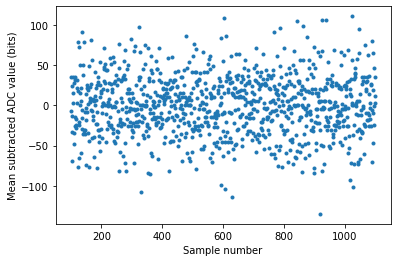

In [21]:
sample_indices = np.arange(n_samples)

start = int(1e2)
stop = int(1e2+1e3)


fig,ax = plt.subplots(1,1)
ax.plot(sample_indices[start:stop],data[start:stop],'.')
ax.set_xlabel('Sample number')
ax.set_ylabel('Mean subtracted ADC value (bits)')


## Make a histogram of the data

Make a histogram of your samples (non-squared), and plot a Gaussian over it (hint: scipy.stats.pdf is a useful function to plot a gaussian). Use your samples' mean and variance to plot that Gaussian. Does the Gaussian line up with your histogram?

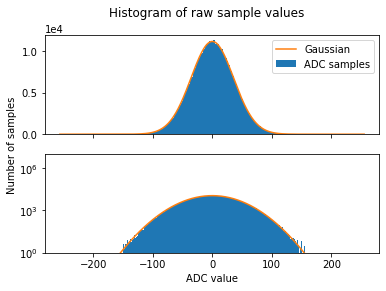

In [22]:
fig,ax = plt.subplots(2,1,sharex=True)
x = np.arange(-2**8,2**8,1)
ax[0].hist(data,bins = x, label = 'ADC samples');
ax[0].plot(x,st.norm.pdf(x-data.mean(),scale=data.var() ** 0.5) * n_samples, label = 'Gaussian')
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].legend()

ax[1].hist(data,bins = x, log=True);
ax[1].plot(x,st.norm.pdf(x-data.mean(),scale=data.var() ** 0.5) * n_samples)
ax[1].set_ylim([1,1e7])
ax[1].set_xlabel('ADC value')

fig.text(0.05,0.5,'Number of samples',rotation=90,ha='center',va='center')
fig.suptitle('Histogram of raw sample values');

## Plot the power or system temperature over time

Plot the power, or system temperature, over time. Here, the power and the system temperature are equivalent because we do not know the constant of proportionality that would relate either of them to the units of bits squared. I recommend you plot the whole time interval, but by averaging every $k$ samples, with $k$ of the order 1000.

Text(0, 0.5, 'System temperature (bits^2)')

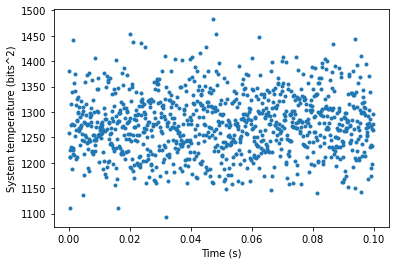

In [4]:
power = data ** 2

avg_window_size = 1000

temperatures = power.reshape(-1,avg_window_size).mean(axis=1)
times = delta_t * avg_window_size * np.arange(n_samples/avg_window_size)

fig,ax = plt.subplots(1,1)
ax.plot(times,temperatures,'.')
ax.set_xlabel('Time (s)')
ax.set_ylabel('System temperature (bits^2)')

## Make a histogram of the power

Make histograms of your power data. Then, plot the histograms of sums of your data. For instance, sum every $k$ samples together, and make a histogram of the resulting sums. Try different $k$'s (e.g. 1,2,4,10,100), and compare it to the corresponding $\chi^2$ distribution (hint: scipy.statschi2 is a useful function to plot $\chi^2$ distributions). Do the $\chi^2$ distribution match up with your histograms? What happens to the distribution for large $k$'s?

Here are some additional hints: scale both axes logarithmically, for instance using ax.set_xscale('log') and similarly for yscale. If you do so, set the lower limit of the y-axis to 1 because the $\chi^2$ distribution is still defined below 1, which means in a log plot, there would be no lower limit, but your histogram is integer-valued so the range between 0 and 1 contains no useful information.

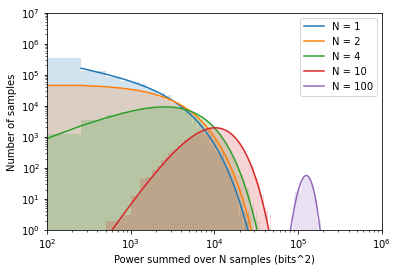

In [6]:
def integrate(power,n_to_integrate):
    return power[:n_to_integrate*int(power.size/n_to_integrate)].reshape(-1,n_to_integrate).sum(axis=1)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig,ax = plt.subplots(1,1,sharex=True)
bin_width = 0.2
x = np.arange(0,400,bin_width)
DoF = [1,2,4,10,100]
for i in range(len(DoF)):
    plt.hist(integrate(power,DoF[i]),bins = x * data.var(),log=True,alpha = 0.2, color = colors[i]);
    plt.loglog(x*data.var(),st.chi2.pdf(x,DoF[i])*power.size/DoF[i]*bin_width, label = 'N = ' + str(DoF[i]), color = colors[i])
ax.set_xscale('log')
ax.set_xlim([1e2,1e6]);
ax.set_ylim([1e0,1e7]);
ax.set_xlabel('Power summed over N samples (bits^2)')
ax.set_ylabel('Number of samples')
ax.legend()

## Check the radiometer equation in the time domain

Here is the radiometer equation again:

\begin{equation}
    \frac{\sigma_T}{T} = \sqrt{\frac{2}{k}} = \sqrt{\frac{1}{t\Delta \nu}}.
\end{equation}


In the theory notebook, we talk about the radiometer equation in the context of Fourier transforms. However, you can check that it holds even as we're still in the time domain. It may be simpler to use the $\sqrt{2/k}$ formulation, where $k$ just becomes an average over a number of time samples, but you're encouraged to think about the $\sqrt{1/(t\Delta\nu)}$ formulation too.

Note also that it does not matter that we do not have the constant of proportionality to obtain the correct value of $T$ in kelvins, since we only need the *relative* uncertainty. That, we can readily obtain since the constants of proportionality will cancel out!

In [7]:
n_avg_window = 1000
T_averaged = (data ** 2).reshape(-1,n_avg_window).mean(axis=1)

print("Using the averaged data and the 2/k formula:")
print(r"Relative uncertainty = " + "{:.4f}".format(T_averaged.std()/T_averaged.mean()))
print("(2/k)^0.5 = " + "{:.4f}".format((2/n_avg_window)**0.5)) # using the 2/k



# To use the (t \delta_\nu) ** (-0.5) formula, you have to either use the non-averaged temperatures,
# or re-scale the t and \delta \nu. I'll use the non-avergaed temperatures
# Note that if I don't average the temperatures, k=1 and t = delta_t
print("\nUsing the non-averaged data and the t \delta \nu formula:")
print(r"Relative uncertainty = " + "{:.4f}".format((data**2).std()/(data**2).mean()))
print(r"(t Delta nu)^0.5 = " + "{:.4f}".format( ( delta_t * bandwidth ) ** -.5 ))

Using the averaged data and the 2/k formula:
Relative uncertainty = 0.0468
(2/k)^0.5 = 0.0447

Using the non-averaged data and the t \delta 
u formula:
Relative uncertainty = 1.4130
(t Delta nu)^0.5 = 1.4142


## Plot a power spectrum in dB

If needed, double-check the definition of the power spectrum in the theory notebook, and plot it.
Here are some recommendations:
- Cut your data into smaller chunks of length $n$, and Fourier transform each of these chunks. Note that the result of these Fourier transforms will have length $n/2$, so you might want to choose the number of frequency bins you want, and have the length of the chunks be twice that number, to avoid having to do any re-binning.
- **Fast Fourier Transforms (FFTs)**, the most common numerical implementation of discrete Fourier transforms, are the fastest when they transform data with length of a power of 2. For the small data sets we are using here, it will make no noticeable difference, but it's good practice to always choose such lengths when possible. Hence, I recommend $n$=1024 or $n$=2048.
- Hint: Numpy's Fourier transform function (numpy.fft.fft()) may come in handy. It will produce outputs of lengths $n$ (instead of $n/2$), but half of the data is redundant. Read its documentation if you've never used it!
- Write a function that will chop up your data and do the Fourier transform, because you may need to do it again further down in the notebook.
- For a first try, just plot the mean spectrum over all your time chunks. You will get an idea of the shape of the output.
- In our context, the band we look at is arbitrary. In real life, you might want to avoid bands that are contaminated by **radio frequency intereference (RFI)**, e.g. cellphone signals. I chose 1200 MHz to be my intermediate frequency when preparing and testing this notebook, so that my band is 1200 MHz to 1205 MHz.

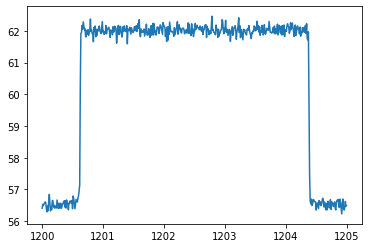

In [8]:
n_freqs = 512 # Number of frequency bins
intermediate_frequency = 1200e6 # in Hz, determines where the band starts
freqs = np.linspace(0,bandwidth,n_freqs)+intermediate_frequency # The frequencies
fm = freqs / 1e6 # The frequencies, in MHz

def dB(lin):
    return 10 * np.log10(lin)

def get_spectrum(data):
    return np.abs(np.fft.fft( data[:2*n_freqs*int(data.size/n_freqs/2)].reshape(-1,n_freqs*2),axis = 1)[:,:n_freqs])**2


spectrum = get_spectrum(data)

fig,ax = plt.subplots(1,1)

ax.plot(fm,dB(spectrum.mean(axis=0)))

## Check the radiometer equation relation in the frequency domain

Now that we are in the frequency domain, it makes sense to check the radiometer equation again. **For each frequency bin**, compute the ratio

\begin{equation}
    \frac{\sigma_T / T}{1/\sqrt{t\Delta \nu}}.
\end{equation}

Then, plot this ratio against the frequencies, and if the radiometer equation holds, it should be a flat line at 1. This this by integrating over different number of time samples to get the power spectrum, and see what happens.

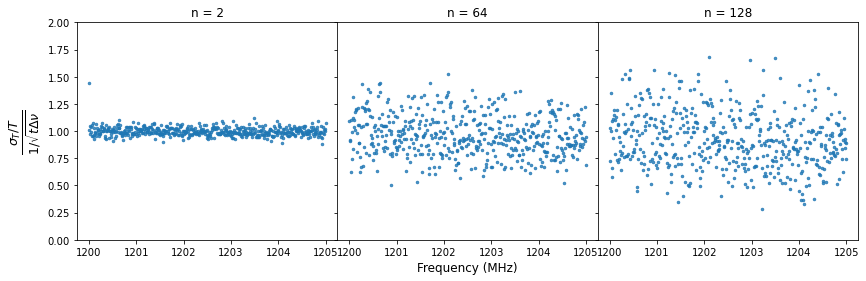

In [9]:
def radiometer_equation_compare(spectrum , n_integration):
    spectrum_std = spectrum[:n_integration*int(spectrum.shape[0]/n_integration),:].reshape(-1,n_integration,n_freqs).mean(axis=1).std(axis=0)
    spectrum_mean = spectrum.mean(axis = 0)
    
    # Here, we have to multiply n_integration by 2 because we discarded half the data in the Fourier transform
    rhs = (2 / (n_integration * 2)) ** 0.5
    #rhs = (1 /  (n_integration * 2 * delta_t * bandwidth) ) ** 0.5
   

    return spectrum_std / spectrum_mean / rhs

spectrum = get_spectrum(data)

fig, ax = plt.subplots(1,3,sharey=True,figsize=[14,4])
plt.subplots_adjust(wspace=0)
n_integrations = [2,64,128]

for i in range(len(n_integrations)):
    ax[i].plot(fm,radiometer_equation_compare(spectrum,n_integrations[i]),'.',markersize = 5,alpha = 0.8)
    ax[i].set_ylim([0.0,2])
    ax[i].set_title('n = '+ str(n_integrations[i]))
ax[1].set_xlabel('Frequency (MHz)',fontsize=12)
ax[0].set_ylabel(r'$\frac{\sigma_T/T}{1/\sqrt{t\Delta\nu}}$',fontsize=18);
#fig.suptitle('Radiation equation uncertainty vs measured standard deviation for different integration times',y=0.92)



## Waterfall plot of the data

Plot a waterfall plot of the data. Since we are using mock data, there should not be any notable feature throughout time.

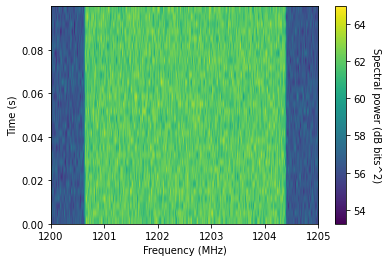

In [10]:
spectrum = get_spectrum( data )
n_integration = 32
integrated_spectrum = spectrum[0:2*n_integration*int(spectrum.shape[0]/n_integration/2),:].reshape(-1,n_integration,n_freqs).mean(axis = 1)

fix, ax = plt.subplots(1,1)
im = ax.imshow(dB(integrated_spectrum),extent = [np.amin(fm),np.amax(fm),0,2 * spectrum.size * delta_t],aspect = 'auto')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Time (s)')
plt.colorbar(im).set_label('Spectral power (dB bits^2)',rotation = 270,labelpad=15)
plt.show()

## Collect data at various load temperatures


We will look at what happens when we vary the temperature of the load. First, collect data at various temperatures. You are lucky, you simply have to change the "T" argument in the collect_data() function instead of submerging the resistor in boiling water! I recommend using temperature that range between 200 and 400, and using 3 to 5 different temperatures. It will take longer to collect the data than the first time around.

In [11]:
n_samples = int(1e6)
Ts = [200,250,300,350]

data_Ts = np.zeros([len(Ts),n_samples])

for i in range(len(Ts)):
    data_Ts[i] = collect_data(n_samples=n_samples,T = Ts[i])
data_Ts = (data_Ts.transpose() - data_Ts.mean(axis=1)).transpose()

Plot the system temperature of those data sets, with time as the x-axis, and the system temperature in bits squared as the y-axis.

Text(0.5, 0.98, 'System temperature estimate vs time')

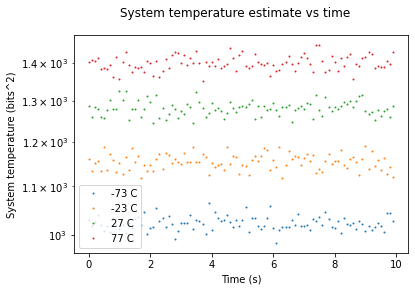

In [12]:
integrating_over = 10000
n_shorter = integrating_over * int(data_Ts.shape[1]/integrating_over)
times = delta_t * n_shorter * np.arange(n_shorter/integrating_over)
fig, ax = plt.subplots()
for i in range(len(Ts)):
    temperatures = (data_Ts[i][:n_shorter] ** 2).reshape(-1,integrating_over).mean(axis = 1)
    ax.semilogy(times,temperatures[:],'.',markersize = 2,label = str(Ts[i]-273) + ' C')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('System temperature (bits^2)')
fig.suptitle('System temperature estimate vs time')

Make histograms of the data for each of those temperatures.

Text(0.06, 0.5, 'Number of samples')

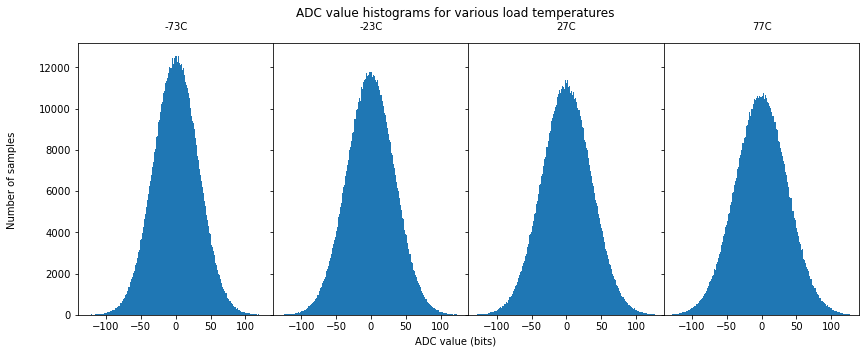

In [13]:
x =np.arange(-2**7,2**7,1)
fig, ax = plt.subplots(1,len(Ts),sharey=True,figsize = [14,5])
plt.subplots_adjust(wspace=0)
max_n = 0

for i in range(len(Ts)):
    n,_,_ = ax[i].hist(data_Ts[i],bins = x);
    if np.max(n) >= max_n:
        max_n = np.max(n)
        
for i in range(len(Ts)):
    ax[i].text(0,1.1 * max_n, str(Ts[i] - 273) + 'C',ha='center');

fig.suptitle('ADC value histograms for various load temperatures')
fig.text(0.5,0.05,'ADC value (bits)',ha='center',va='center')
fig.text(0.06,0.5,'Number of samples',ha='center',va='center',rotation = 90)

Text(0.5, 0.98, 'Histogram of ADC values vs load temperatures')

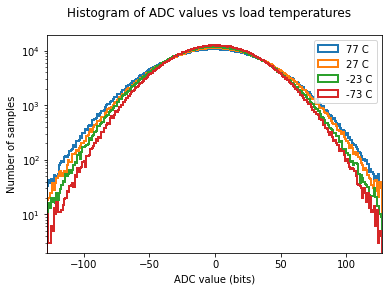

In [14]:
fig,ax = plt.subplots()
for i in range(len(Ts))[::-1]:
    ax.hist(data_Ts[i],bins = x,histtype = 'step',linewidth=2, log=True, label = str(Ts[i]-273) + ' C');
    
ax.legend()
ax.set_xlabel('ADC value (bits)')
ax.set_ylabel('Number of samples')
ax.set_xlim([x[0],x[-1]])
fig.suptitle('Histogram of ADC values vs load temperatures')

## Spectrum vs load temperature

Generate the spectrum at the different temperatures you collected, and compare them (you can average the spectrum over all the samples).

Text(0.5, 0.98, 'Load temperature vs spectral power')

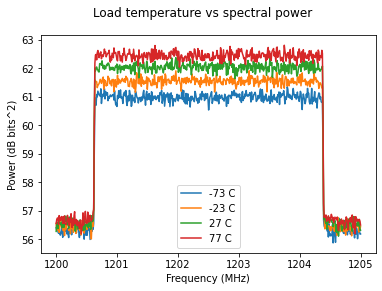

In [15]:
fig,ax = plt.subplots()
for i in range(len(Ts)):
    ax.plot(fm,dB(get_spectrum(data_Ts[i]).mean(axis=0)), label = str(Ts[i]-273) + ' C')
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Power (dB bits^2)')
ax.legend()
fig.suptitle('Load temperature vs spectral power')

## Plot the power vs. load temperature, and do a linear fit

For our toy model, the system temperature can be expressed as

\begin{equation}
    T_{sys} = T_{load} + T_{receiver}.
\end{equation}

We want to know $T_{receiver}$. We know $T_{load}$, but we only know $T_{sys}$ up to some proportionality constant. In other words, we know $P_{sys} = k T_{sys}$, where $P_{sys}$ has units of bits squared, and $k$ is some unknown proportionality constant that converts a temperature in kelvins to a power in bits squared. We can thus write

\begin{equation}
    P_{sys} = k\left(T_{load} + T_{receiver}\right).
\end{equation}

Hence, if we plot $P_{sys}$ against $T_{load}$, the slope will be $k$, and the y-intercept divided by $k$ will be $T_{receiver}$! Now, you do this.

Text(0.2, 0.8, 'Receiver temperature:  208 K')

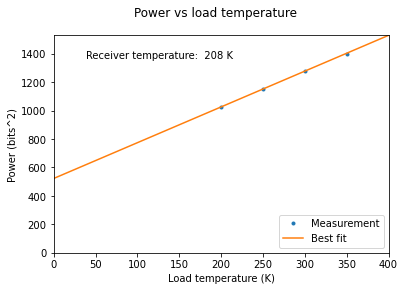

In [16]:
f = np.polyfit(Ts, [data_Ts[i].var() for i in range(len(Ts))], 1)
temp_receiver = f[1]/f[0]
temp_range = np.array([0,400])

fig,ax = plt.subplots()
ax.plot(Ts, [data_Ts[i].var() for i in range(len(Ts))],'.', label = 'Measurement')
ax.set_xlim(temp_range)
ax.set_ylim([0,temp_range[-1] * f[0] + f[1]])
ax.set_xlabel('Load temperature (K)')
ax.set_ylabel('Power (bits^2)')
fig.suptitle('Power vs load temperature')
ax.plot(temp_range,f[1]+f[0]*temp_range, label = 'Best fit')
ax.legend(loc='lower right')
fig.text(0.2,0.8,'Receiver temperature: {:4.0f} K'.format(temp_receiver))

## Receiver temperature vs spectral bin

Note that the temperature you just computed is the average over the whole band, but a good calibration would involve knowing the receiver temperature *per frequency*. This can be done with the exact same method, but going frequency-by-frequency with the power spectra you computed above.

Text(0.5, 0, 'Frequency (MHz)')

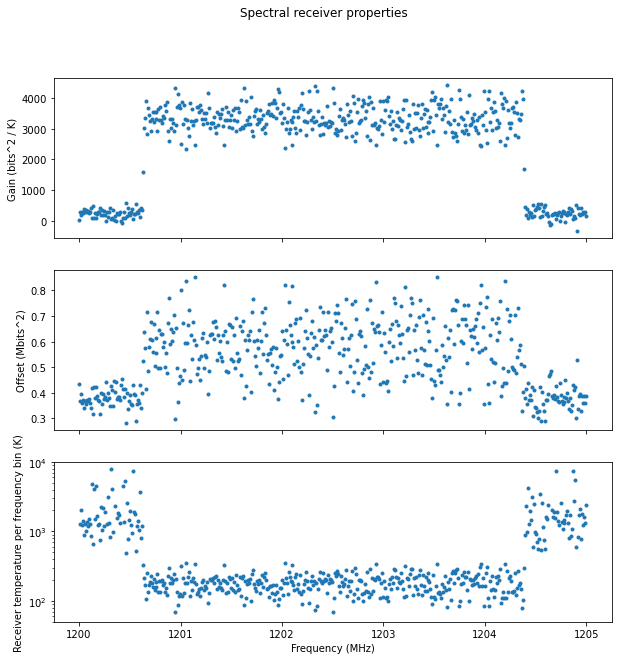

In [17]:
fits = np.zeros([n_freqs,2])
spectrum_Ts = np.zeros([len(Ts),n_freqs])
for i in range(len(Ts)):
    spectrum_Ts[i] = get_spectrum(data_Ts[i]).mean(axis=0)
for i in np.arange(n_freqs):
    fits[i,:]=np.polyfit(Ts, [spectrum_Ts[j][i] for j in range(len(Ts))],1 )

fig, ax = plt.subplots(3,sharex=True,figsize=[10,10])

ax[0].plot(fm,fits[:,0],'.')
#ax[0].set_ylim([0,0])
ax[0].set_ylabel('Gain (bits^2 / K)')

ax[1].plot(fm,fits[:,1]/1e6,'.')
#ax[1].set_ylim([0,0])
ax[1].set_ylabel('Offset (Mbits^2)')

ax[2].semilogy(fm,fits[:,1]/fits[:,0],'.')
ax[2].set_ylim([5e1,1e4])
ax[2].set_ylabel('Receiver temperature per frequency bin (K)')

fig.suptitle('Spectral receiver properties')
ax[2].set_xlabel('Frequency (MHz)')